In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch_geometric.datasets import TUDataset, Planetoid

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from tqdm.notebook import tqdm

## Sample Graph Data

In [5]:
# edge_index = torch.tensor([[0, 1, 1, 2],
                        #    [1, 0, 2, 1]], dtype=torch.long)
edge_index = torch.tensor([[0,1],
                          [1,0],
                          [1,2],
                          [2,1]],
                          dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index.T.contiguous())

print(data)
# data

Data(x=[3, 1], edge_index=[2, 4])


## Common Benchmark Datasets

In [6]:
dataset = TUDataset(root='./data/ENZYMES', name='ENZYMES', use_node_attr=True)

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: ENZYMES(600):
Number of graphs: 600
Number of features: 21
Number of classes: 6


In [7]:
dataset[0]

Data(edge_index=[2, 168], x=[37, 21], y=[1])

In [8]:
print("Number of classes: ", dataset.num_classes, 
      "\nNumber of edge features: ", dataset.num_edge_features, 
      "\nNumber of node features: ", dataset.num_node_features)

Number of classes:  6 
Number of edge features:  0 
Number of node features:  21


Visualize the dataset

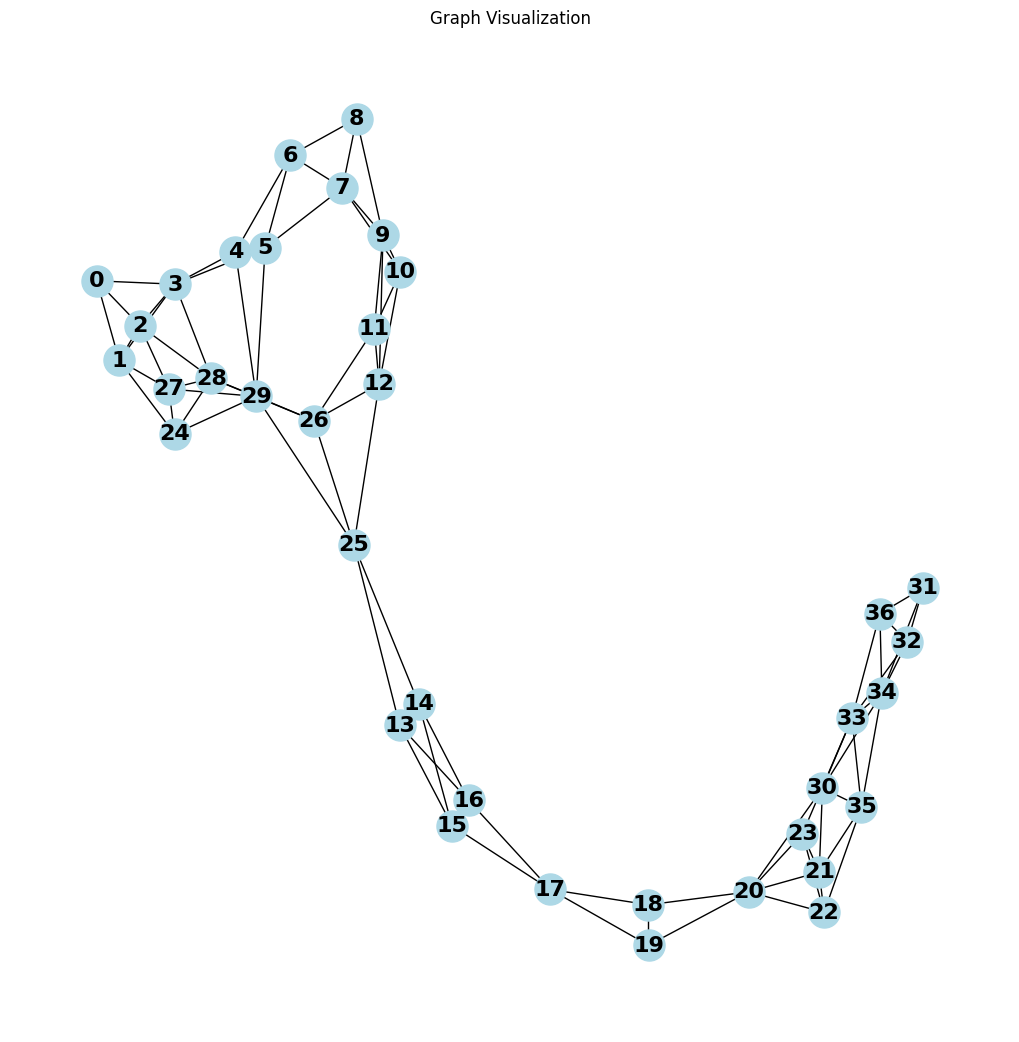

Data(edge_index=[2, 168], x=[37, 21], y=[1])


In [9]:


def visualize_graph(data):
    # Convert PyTorch Geometric graph to NetworkX graph
    G = nx.Graph()
    
    # Add nodes
    for i in range(data.num_nodes):
        G.add_node(i, features=data.x[i].tolist())
    
    # Add edges
    edge_index = data.edge_index.cpu().numpy()
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])
    
    # Draw the graph
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=16, font_weight='bold')
    plt.title("Graph Visualization")
    plt.show()

# Visualize the first graph in the dataset
visualize_graph(dataset[0])
print(dataset[0])

Graph datasets are structured as nodes and edges. 
- Edges are a tuple indicating (src_node, dst_node)
- Every node shall contains num_features defined by the graph
- Edges can either be directed or undirected
- Graph can either be cyclic or acyclic

## Loading dataset in batches

In [10]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)
for batch in loader:
    print(batch)
    print(batch.num_graphs)
    break
    
    

DataBatch(edge_index=[2, 3896], x=[1005, 21], y=[32], batch=[1005], ptr=[33])
32


In [11]:
dataset[0]

Data(edge_index=[2, 168], x=[37, 21], y=[1])

In [12]:
# visualize_graph(batch[0])
# print(batch[0])
batch[0].x.shape

torch.Size([11, 21])

## Types of GNN Tasks
1) Graph Classification: classify graphs into various categories
2) Node Classification: classify nodes into different categories
3) Link/Edge Prediction: predicts links between a pair of nodes in a graph
4) Graph Embedding: Embed graphs into vectors preserving relevent information on nodes, edges and structure
5) Graph Generation: Learns graph distribution from sample and generate a new graph

## GNN Classifiction
## Training a GNN

The GNN model is created with Graph Convolution layer which works similar to Convolution lateyers in  CNN for images. 

***Dataset: Cora***

The dataset used is `Cora` which contains 2708 scientific publications classified into one of seven classes.  The citation network contains 5429 links/edges. Each paper is represeted by a binary word vector (embedding) of length 1433 derived from dictionary of 1433 unique words. (Similar to Bag of words)


**References**
1) https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial

In [13]:
# Load the dataset
dataset = Planetoid(root='./data/Cora', name='Cora')

# Print the dataset
# print("Dataset: ", dataset)
print("Number of nodes: ", dataset.data.x.shape[0])
print("Number of edges: ", dataset.data.edge_index.shape[1])
print("Number of features: ", dataset.data.x.shape[1])
print("Number of classes: ", dataset.num_classes)

# print("Number of nodes: ", dataset.num_node_features) #dataset.data.x.shape[0])

Number of nodes:  2708
Number of edges:  10556
Number of features:  1433
Number of classes:  7


/Users/rajesh/dev/repos/deep_learning/.venv/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [14]:
# Create a GNN model
class GNN(torch.nn.Module):
    def __init__(self, nfeats, nclasses):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(nfeats, 16)
        self.conv2 = GCNConv(16, nclasses)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [15]:
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_built() else "cpu")
print(f"Using device: {device}")

# Create the model, device, and optimizer
model = GNN(dataset.num_node_features, dataset.num_classes)
model = model.to(device)

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Create the loss function
loss_fn = torch.nn.NLLLoss()

print(model)

Using device: mps
GNN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Train model

In [16]:
data = dataset[0].to(device)

# Create the training loop
model.train()
for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    # print(f"Epoch {epoch}, Loss: {loss.item()}")


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluate the model

In [17]:
# evaluate the model
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8030


Visualize

In [45]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    print(type(z))

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

/Users/rajesh/dev/repos/deep_learning/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/rajesh/dev/repos/deep_learning/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/rajesh/dev/repos/deep_learning/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/rajesh/dev/repos/deep_learning/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/rajesh/dev/repos/deep_learning/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/rajesh/dev/repos/deep_learning/.venv/lib/python3.12/site-packages/sklearn/utils/extmath

<class 'numpy.ndarray'>


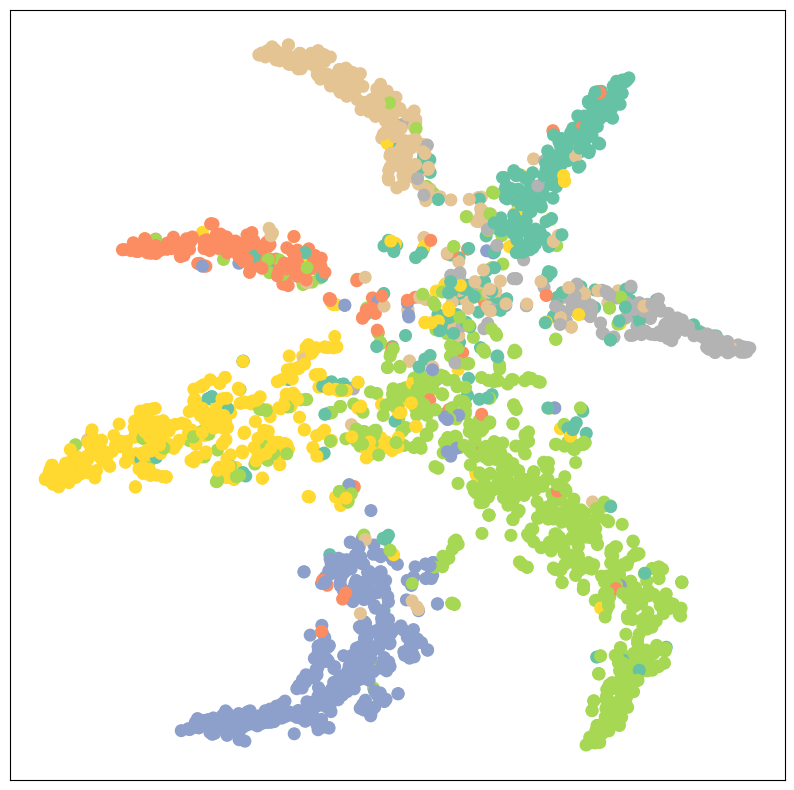

In [50]:
model.eval()
out = model(data)
visualize(out, color=data.y.cpu().numpy())


In [49]:
data.y.cpu().numpy()

array([3, 4, 4, ..., 3, 3, 3])